In [ ]:
!pip install shap lime tensorflow transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9f812fd201cd3c3013c87b513e36b84708b06d147f3c00ddd00e6646f04e2a50
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten,
    Dropout, Input, LayerNormalization, MultiHeadAttention
)

import shap
from lime.lime_tabular import LimeTabularExplainer


In [ ]:
from google.colab import files

uploaded = files.upload()   # Opens file picker


Saving C MAPSS DATA.csv to C MAPSS DATA.csv


In [ ]:
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

df.head()


,unit_number,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,dataset,RUL,Failure
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392.0,2388.0,100.0,39.06,23.4190,FD001,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392.0,2388.0,100.0,39.00,23.4236,FD001,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390.0,2388.0,100.0,38.95,23.3442,FD001,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392.0,2388.0,100.0,38.88,23.3739,FD001,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393.0,2388.0,100.0,38.90,23.4044,FD001,187,0


In [ ]:
# Remove non-numeric & unused columns
df_clean = df.drop(columns=['dataset', 'Failure'])


In [ ]:
def create_sequences_per_engine(df, time_steps=30):
    Xs, ys = [], []

    for unit in df['unit_number'].unique():
        unit_df = df[df['unit_number'] == unit]

        X_unit = unit_df.drop(columns=['RUL']).values
        y_unit = unit_df['RUL'].values

        for i in range(len(X_unit) - time_steps):
            Xs.append(X_unit[i:i+time_steps])
            ys.append(y_unit[i+time_steps])

    return np.array(Xs), np.array(ys)


In [ ]:
TIME_STEPS = 30
X_seq, y_seq = create_sequences_per_engine(df_clean, TIME_STEPS)


In [ ]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_seq = scaler_X.fit_transform(
    X_seq.reshape(-1, X_seq.shape[2])
).reshape(X_seq.shape)

y_seq = scaler_y.fit_transform(y_seq.reshape(-1, 1))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)


Epoch 1/10
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 111s 33ms/step - loss: 0.0134 - val_loss: 0.0138
Epoch 2/10
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 138s 32ms/step - loss: 0.0089 - val_loss: 0.0133
Epoch 3/10
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 100s 32ms/step - loss: 0.0081 - val_loss: 0.0121
Epoch 4/10
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 99s 32ms/step - loss: 0.0076 - val_loss: 0.0129
Epoch 5/10
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 140s 31ms/step - loss: 0.0072 - val_loss: 0.0134
Epoch 6/10
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 100s 32ms/step - loss: 0.0069 - val_loss: 0.0124
Epoch 7/10
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 141s 32ms/step - loss: 0.0068 - val_loss: 0.0117
Epoch 8/10
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 140s 31ms/step - loss: 0.0068 - val_loss: 0.0119
Epoch 9/10
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 145s 32ms/step - loss: 0.0067 - val_loss: 0.0121
Epoch 10/10
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 98s 31ms/step - loss: 0.0066 - val_loss: 0.0140


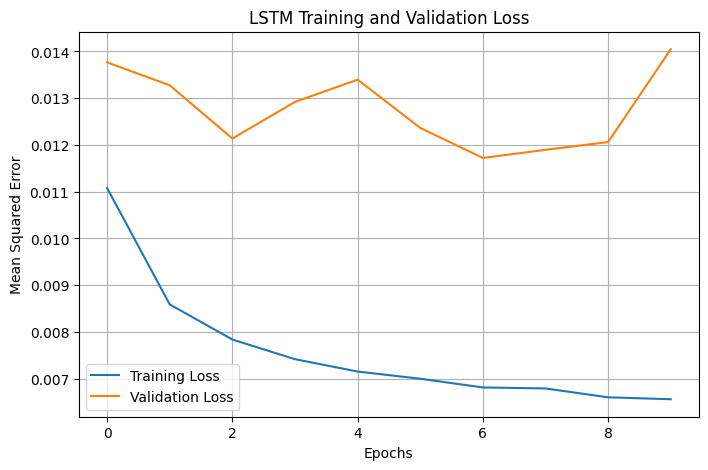

In [ ]:
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(TIME_STEPS, X_seq.shape[2])),
    LSTM(32),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')


history = lstm_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('LSTM Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 126s 37ms/step - loss: 0.0138 - val_loss: 0.0218
Epoch 2/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 144s 38ms/step - loss: 0.0089 - val_loss: 0.0121
Epoch 3/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 137s 36ms/step - loss: 0.0082 - val_loss: 0.0128
Epoch 4/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 145s 37ms/step - loss: 0.0076 - val_loss: 0.0119
Epoch 5/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 142s 37ms/step - loss: 0.0073 - val_loss: 0.0121
Epoch 6/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 115s 37ms/step - loss: 0.0071 - val_loss: 0.0120
Epoch 7/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 141s 36ms/step - loss: 0.0067 - val_loss: 0.0120
Epoch 8/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 146s 38ms/step - loss: 0.0065 - val_loss: 0.0132
Epoch 9/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 118s 38ms/step - loss: 0.0060 - val_loss: 0.0164
Epoch 10/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 116s 37ms/step - loss: 0.0053 - val_loss: 0.0142
Epoch 11/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 120s 38ms/step - loss: 0.0048 - val_loss: 0.01

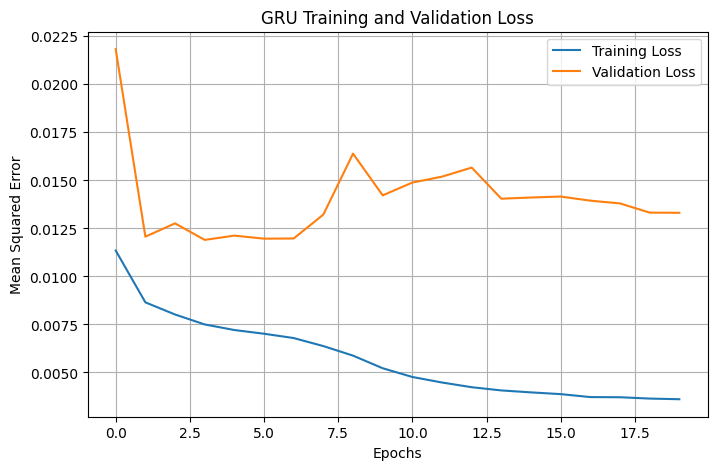

In [ ]:
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(TIME_STEPS, X_seq.shape[2])),
    GRU(32),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse')

history_gru = gru_model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1
)

plt.figure(figsize=(8,5))
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('GRU Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0165 - val_loss: 0.0139
Epoch 2/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0092 - val_loss: 0.0123
Epoch 3/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0082 - val_loss: 0.0135
Epoch 4/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0079 - val_loss: 0.0131
Epoch 5/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0078 - val_loss: 0.0125
Epoch 6/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0074 - val_loss: 0.0159
Epoch 7/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0071 - val_loss: 0.0127
Epoch 8/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0070 - val_loss: 0.0126
Epoch 9/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0070 - val_loss: 0.0129
Epoch 10/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0068 - val_loss: 0.0150
Epoch 11/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0066 - val_loss: 0.0160
Epoch 12/20
3130/31

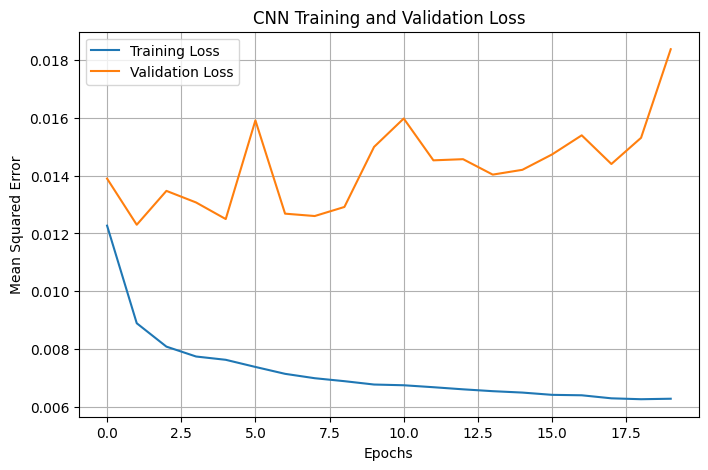

In [ ]:
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(TIME_STEPS, X_seq.shape[2])),
    MaxPooling1D(2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

cnn_model.compile(optimizer='adam', loss='mse')

history_cnn = cnn_model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1
)

plt.figure(figsize=(8,5))
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('CNN Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 57s 17ms/step - loss: 0.0681 - val_loss: 0.0173
Epoch 2/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 56s 18ms/step - loss: 0.0132 - val_loss: 0.0166
Epoch 3/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 60s 19ms/step - loss: 0.0107 - val_loss: 0.0127
Epoch 4/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 54s 17ms/step - loss: 0.0093 - val_loss: 0.0142
Epoch 5/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 56s 18ms/step - loss: 0.0090 - val_loss: 0.0124
Epoch 6/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 57s 18ms/step - loss: 0.0084 - val_loss: 0.0127
Epoch 7/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 55s 18ms/step - loss: 0.0083 - val_loss: 0.0120
Epoch 8/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 55s 18ms/step - loss: 0.0082 - val_loss: 0.0118
Epoch 9/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 57s 18ms/step - loss: 0.0078 - val_loss: 0.0127
Epoch 10/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 56s 18ms/step - loss: 0.0079 - val_loss: 0.0122
Epoch 11/20
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 86s 19ms/step - loss: 0.0077 - val_loss: 0.0145
Epoch 12

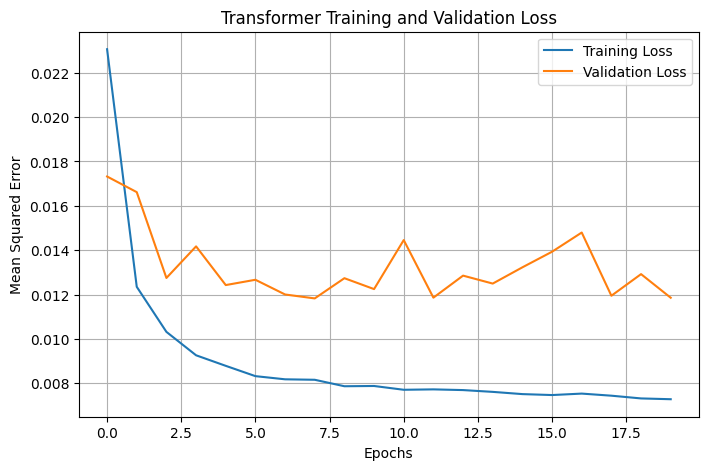

In [ ]:
inputs = Input(shape=(TIME_STEPS, X_seq.shape[2]))

x = MultiHeadAttention(num_heads=4, key_dim=32)(inputs, inputs)
x = LayerNormalization()(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1)(x)

transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer='adam', loss='mse')

history_transformer = transformer_model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1
)

plt.figure(figsize=(8,5))
plt.plot(history_transformer.history['loss'], label='Training Loss')
plt.plot(history_transformer.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Transformer Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


870/870 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step


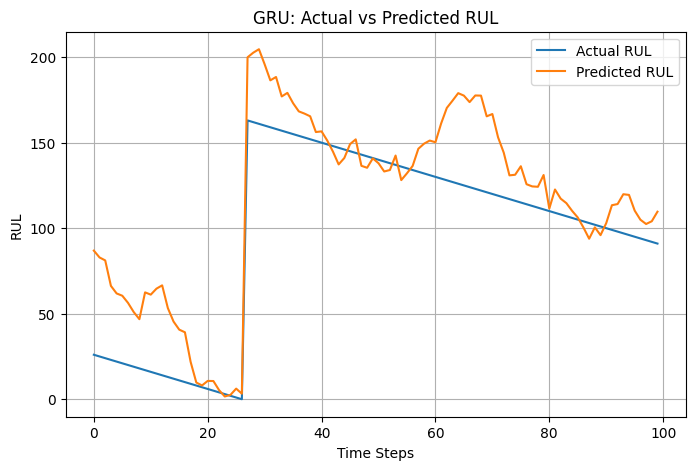

870/870 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


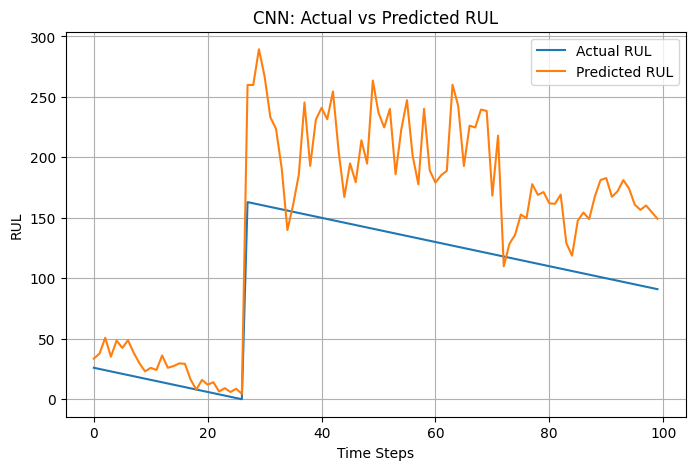

870/870 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


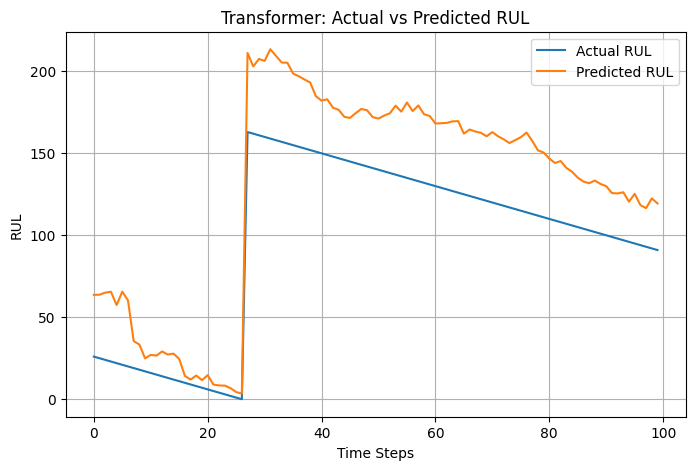

In [ ]:
def plot_actual_vs_pred(model, title):
    y_pred = model.predict(X_test)
    y_test_inv = scaler_y.inverse_transform(y_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)

    plt.figure(figsize=(8,5))
    plt.plot(y_test_inv[:100], label='Actual RUL')
    plt.plot(y_pred_inv[:100], label='Predicted RUL')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('RUL')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_actual_vs_pred(gru_model, "GRU: Actual vs Predicted RUL")
plot_actual_vs_pred(cnn_model, "CNN: Actual vs Predicted RUL")
plot_actual_vs_pred(transformer_model, "Transformer: Actual vs Predicted RUL")
